In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mgimg
import matplotlib.colors as colors
import scipy as sp
import numpy as np
import emcee
import testkit
import corner
import pickle as pickle
from IPython.display import display
%matplotlib inline
import forwardmodel
import ciamod
import TPmod
import cloud
import band
from astropy.convolution import convolve, convolve_fft
from astropy.convolution import Gaussian1DKernel
from scipy.interpolate import griddata
from scipy.io.idl import readsav
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline
from mikesconv import instrument_non_uniform

In [2]:
print forwardmodel.marv.__doc__

outspec,phot_press,tau_spec,cfunc = marv(temp,logg,r2d2,ingasnum,logvmr,pcover,do_clouds,incloudnum,cloudrad,cloudsig,cloudprof,inlinetemps,inpress,inwavenum,inlinelist,cia,ciatemps,use_disort,make_pspec,make_tspec,make_cf,do_bff,bff)

Wrapper for ``marv``.

Parameters
----------
temp : in/output rank-1 array('d') with bounds (f2py_temp_d0)
logg : input float
r2d2 : input float
ingasnum : in/output rank-1 array('i') with bounds (f2py_ingasnum_d0)
logvmr : in/output rank-2 array('d') with bounds (f2py_logvmr_d0,f2py_logvmr_d1)
pcover : in/output rank-1 array('f') with bounds (f2py_pcover_d0)
do_clouds : in/output rank-1 array('i') with bounds (f2py_do_clouds_d0)
incloudnum : in/output rank-2 array('i') with bounds (f2py_incloudnum_d0,f2py_incloudnum_d1)
cloudrad : in/output rank-3 array('d') with bounds (f2py_cloudrad_d0,f2py_cloudrad_d1,f2py_cloudrad_d2)
cloudsig : in/output rank-3 array('d') with bounds (f2py_cloudsig_d0,f2py_cloudsig_d1,f2py_cloudsig_d2)
cloudprof : in/output rank-3 

In [3]:
def get_endchain(pic):
    with open(pic, 'rb') as input:
        chain,probs = pickle.load(input) 
    nwalkers = chain.shape[0]
    niter = chain.shape[1]
    ndim = chain.shape[2]
    flatprobs = probs[:,:].reshape((-1))
    max_like = flatprobs[np.argmax(probs)]
    print max_like
    flatendchain = chain[:,niter-2000:,:].reshape((-1,ndim))
    flatendprobs = probs[:,niter-2000:].reshape((-1))
    theta_max_end = flatendchain[np.argmax(flatendprobs)]
    max_end_like = np.amax(flatendprobs)
    return flatendchain, flatendprobs,ndim

In [4]:
flatendchain, flatendprobs,ndim = get_endchain("2m0500_pow_thick.pic")
theta_max_end = flatendchain[np.argmax(flatendprobs)]
max_end_like = np.amax(flatendprobs)
print max_end_like

5004.29937981
5003.26489273


In [5]:
print theta_max_end

[ -3.31143612e+00  -2.78671869e+00  -7.42235235e+00  -8.50563221e+00
  -5.44057042e+00  -7.50521354e+00  -7.79572662e+00  -6.60540225e+00
   5.15390528e+00   3.01609593e-20  -1.74043626e-03  -3.07490673e+01
   6.38379366e-01   2.77163730e+00   8.05903881e-01  -1.61008663e+00
   9.18749875e-01   6.70902893e-02   2.06984865e-01   1.56403691e+00
   3.82502792e+03]


In [6]:
logP = np.arange(-4.0, 2.4, 0.1)  #high res grid
P = 10.**logP
logcoarsePress = np.arange(-4.0, 2.5, 0.53)
print 10.**logcoarsePress
print logcoarsePress.size
print 10.**logP
print logP.size
finePress = P

[  1.00000000e-04   3.38844156e-04   1.14815362e-03   3.89045145e-03
   1.31825674e-02   4.46683592e-02   1.51356125e-01   5.12861384e-01
   1.73780083e+00   5.88843655e+00   1.99526231e+01   6.76082975e+01
   2.29086765e+02]
13
[  1.00000000e-04   1.25892541e-04   1.58489319e-04   1.99526231e-04
   2.51188643e-04   3.16227766e-04   3.98107171e-04   5.01187234e-04
   6.30957344e-04   7.94328235e-04   1.00000000e-03   1.25892541e-03
   1.58489319e-03   1.99526231e-03   2.51188643e-03   3.16227766e-03
   3.98107171e-03   5.01187234e-03   6.30957344e-03   7.94328235e-03
   1.00000000e-02   1.25892541e-02   1.58489319e-02   1.99526231e-02
   2.51188643e-02   3.16227766e-02   3.98107171e-02   5.01187234e-02
   6.30957344e-02   7.94328235e-02   1.00000000e-01   1.25892541e-01
   1.58489319e-01   1.99526231e-01   2.51188643e-01   3.16227766e-01
   3.98107171e-01   5.01187234e-01   6.30957344e-01   7.94328235e-01
   1.00000000e+00   1.25892541e+00   1.58489319e+00   1.99526231e+00
   2.5118864

In [7]:
w1 = 0.7
w2 = 15

dist = 13.54
# hardwired FWHM of data in microns
fwhm = 0.01

npatches = 1
nclouds = 1
pcover = np.ones([npatches],dtype='f')
pcover[:] = 1.0
do_clouds = np.zeros([npatches],dtype='i')
do_clouds[:] = 1
cloudnum = np.zeros([npatches,nclouds],dtype='i')
cloudnum[:,:] = 89
cloudtype = np.asfortranarray(np.ones([npatches,nclouds]),dtype='i')
cloudtype[:,:] = 2

use_disort = 0 

# Set the profile type
proftype = 2

# now the linelist
# Set up number of gases, and point at the lists. see gaslist.dat
ngas = 9
gasnum = np.asfortranarray(np.array([1,4,7,8,9,10,11,20,21],dtype='i'))
lists = ["../Linelists/H2O_xsecs.pic","../Linelists/co_xsecs.pic","../Linelists/tio_xsecs.pic","../Linelists/vo_xsecs.pic","../Linelists/cah_xsecs.pic","../Linelists/crh_xsecs.pic" ,"../Linelists/feh_xsecs.pic","../Linelists/K_xsecs.pic","../Linelists/Na_xsecs.pic"]

In [8]:
# get the basic framework from water list
rawwavenum, inpress, inlinetemps, inlinelist = pickle.load( open('../Linelists/H2O_xsecs.pic', "rb" ) )
print inpress
print inlinetemps

wn1 = 10000./w2
wn2 = 10000. / w1
inwavenum = np.asfortranarray(rawwavenum[np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1)))],dtype='float64')
ntemps = inlinetemps.size
npress= finePress.size
nwave = inwavenum.size
r1 = np.amin(np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1))))
r2 = np.amax(np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1))))

# Here we are interpolating the linelist onto our fine pressure scale.
# pickles have linelist as 4th entry....
linelist = (np.ones([ngas,npress,ntemps,nwave],order='F')).astype('float64', order='F')
for gas in range (0,ngas):
    inlinelist= pickle.load( open(lists[gas], "rb" ) )[3]
    # make missing bits crazy. They are all high pressure, low-temp points.
    #inlinelist[np.isnan(inlinelist)] = 1.0
    for i in range (0,ntemps):
        for j in range (r1,r2+1):
            pfit = interp1d(np.log10(inpress),np.log10(inlinelist[:,i,j]))
            linelist[gas,:,i,(j-r1)] = np.asfortranarray(pfit(np.log10(finePress)))

linelist[np.isnan(linelist)] = -50.0


[  9.99999975e-06   2.99999992e-05   9.99999975e-05   3.00000014e-04
   1.00000005e-03   3.00000003e-03   9.99999978e-03   2.99999993e-02
   1.00000001e-01   3.00000012e-01   1.00000000e+00   3.00000000e+00
   1.00000000e+01   3.00000000e+01   1.00000000e+02   3.00000000e+02]
[   75.    85.   100.   120.   140.   160.   180.   200.   230.   260.
   300.   350.   400.   500.   650.   800.  1000.  1200.  1400.  1600.
  1800.  2000.  2300.  2600.  3000.  3500.  4000.]


In [9]:
tmpcia, ciatemps = ciamod.read_cia("CIA_DS_aug_2015.dat",inwavenum)
cia = np.asfortranarray(np.empty((4,ciatemps.size,nwave)),dtype='float32')
cia[:,:,:] = tmpcia[:,:,:nwave] 
ciatemps = np.asfortranarray(ciatemps, dtype='float32')

In [10]:
alkratio = 16.2 # Asplund+ 2009
logVMR = np.asfortranarray(np.ones([ngas,64]),dtype='float64')
print logVMR.shape
f1 = 1.348
f2 = 8912.5


(9, 64)


In [11]:
outspec = np.zeros((2,nwave),dtype='d')
press = P
ng = 8
nc = 4
nb = 4

obspec = np.loadtxt("2M0500_2MassJcalib_trim.dat",unpack=True)
nobs = obspec.shape[1]

logVMR[0,:] = np.full((npress,),(theta_max_end[0])) # water
logVMR[1,:] = np.full((npress,),(theta_max_end[1])) # CO
logVMR[2,:] = np.full((npress,),(theta_max_end[2])) # TiO
logVMR[3,:] = np.full((npress,),(theta_max_end[3])) # VO
logVMR[4,:] = np.full((npress,),(theta_max_end[4])) # CaH
logVMR[5,:] = np.full((npress,),(theta_max_end[5])) # CrH
logVMR[6,:] = np.full((npress,),(theta_max_end[6])) # FeH
# Now the alkalis
logVMR[7,:]  = np.full((npress,),(np.log10(10.**theta_max_end[7] / (alkratio+1.))))
logVMR[8,:]  = np.full((npress,),(np.log10(10.**theta_max_end[7] * (alkratio / (alkratio+1.)))))
logg = theta_max_end[ng]
R2D2 = theta_max_end[ng+1]
dlam = theta_max_end[ng+2]
cloudparams = np.ones([5,npatches,nclouds],dtype='d')
cloudparams[0,:,:] = 1.0
cloudparams[1,:,:] = theta_max_end[ng+4]
cloudparams[2,:,:] = theta_max_end[ng+5]
cloudparams[3,:,:] = theta_max_end[ng+6]
cloudparams[4,:,:] = theta_max_end[ng+7]
#cloudparams[1:5] = samp[ng+nb:ng+nb+nc]
cloudprof,cloudrad,cloudsig = cloud.atlas(do_clouds,cloudnum,cloudtype,cloudparams,press)
cloudnum = np.asfortranarray(cloudnum,dtype='i')
cloudrad = np.asfortranarray(cloudrad,dtype='float64')
cloudsig = np.asfortranarray(cloudsig,dtype='float64')
cloudprof = np.asfortranarray(cloudprof,dtype='float64')
pcover = np.asfortranarray(pcover,dtype='float32')
press = np.asfortranarray(press,dtype='float32')
temp = TPmod.set_prof(2,10.**logcoarsePress,P,theta_max_end[ndim-5:])
temp = np.asfortranarray(temp,dtype='float64')
logVMR = np.asfortranarray(logVMR,dtype='float64')
do_clouds = np.asfortranarray(do_clouds,dtype='i')
pspec = 0
tspec = 0
make_cf = 1
do_bff = 0
bff = np.asfortranarray(np.ones([3,press.size]), dtype='float64')
tmpoutspec, tmpphotspec, tmptauspec,tmpcfunc = forwardmodel.marv(temp,logg,R2D2,gasnum,logVMR,pcover,do_clouds,cloudnum,cloudrad,cloudsig,cloudprof,inlinetemps,press,inwavenum,linelist,cia,ciatemps,use_disort,pspec,tspec,make_cf,do_bff,bff)
outspec = tmpoutspec[:,:nwave]
#photspec = tmpphotspec[0:npatches,:nwave].reshape(nwave)
#tauspec = tmptauspec[0:npatches,:nwave].reshape(nwave)
#tempspec = TPmod.set_prof(2,10.**logcoarsePress,photspec,theta_max_end[ndim-5:])
cfunc = tmpcfunc[0,:nwave,:press.size]
wlen = outspec.shape[1]
shiftspec = np.empty_like(outspec)
shiftspec[0,:] =  outspec[0,:] + dlam
shiftspec[1,:] =  outspec[1,:]   
wlen = shiftspec.shape[1]
wint =  shiftspec[0,0] - shiftspec[0,wlen-1]
# convolve with instrumental profile
# start by setting up kernel
# First step is finding the array index length of the FWHM
disp = wint / wlen
gwidth = int((((fwhm / disp) // 2) * 2) +1)
# needs to be odd
# now get the kernel and convolve
gauss = Gaussian1DKernel(gwidth)
cspec = convolve(shiftspec[1,:],gauss,boundary='extend')
topspec = np.array(cspec[::-1])
wavenew = shiftspec[0,::-1]

In [12]:
for ilayer in range (0,press.size):
    cfunc[:,ilayer] = convolve(cfunc[:,ilayer],gauss,boundary='extend')

In [13]:
print cfunc.shape
print nwave
print wavenew.shape
print logP.shape
logP = logP.reshape(64,)
print logP.shape
print cfunc.transpose().shape

(13619, 64)
13619
(13619,)
(64,)
(64,)
(64, 13619)


In [14]:
normfunc = np.zeros_like(cfunc)
for iwave in range(0,nwave):
    totcont = np.sum(cfunc[iwave,:])
    normfunc[iwave,:] = cfunc[iwave,:] / totcont


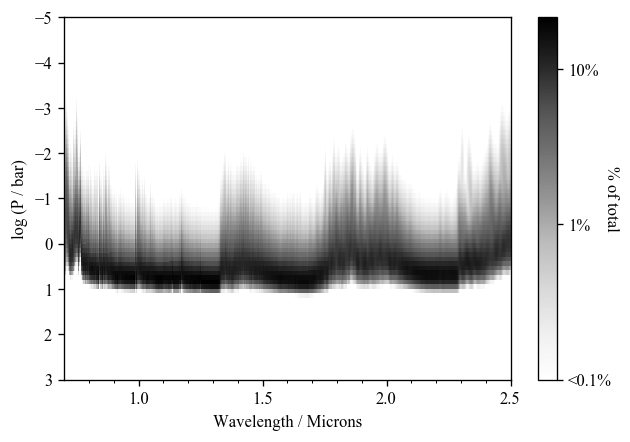

In [15]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=120)
plt.axis([0.7,2.5,3.,-5.0])
ax = fig.add_subplot(1,1,1) 
major_ticks = np.arange(1.0,2.6,0.5)
minor_ticks = np.arange(0.8,2.5,0.1)
ax.set_xticks(major_ticks)                                                       
ax.set_xticks(minor_ticks, minor=True)                                           

plt.pcolormesh(wavenew,logP,(normfunc[::-1,:].transpose()),cmap='Greys',norm=colors.SymLogNorm(linthresh=0.001,linscale=0.00001,
                                              vmin=0., vmax=np.amax(normfunc)))

cbar = plt.colorbar(orientation='vertical',norm=colors.Normalize(clip=False),ticks=[1e-3,1e-2,0.1])
cbar.ax.set_yticklabels(['<0.1%', '1%', '10%'])
cbar.set_label('% of total', rotation=270)
plt.ylabel("log (P / bar)")
plt.xlabel('Wavelength / Microns')
plt.savefig('2M0500_thickPow_contribution.png',format='png', dpi=120)